In [112]:
import os
import json
import geopandas as gpd
import requests
import osmnx as ox
from dotenv import load_dotenv
from sentinelsat import geojson_to_wkt
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from pydantic import BaseModel

In [113]:
class ExtractBox(BaseModel):
    location: str
    distance: float = 1000.0  # Default distance in meters
    filepath: str

def extract_bbox(**kwargs):
    input = ExtractBox(**kwargs)
    location = input.location
    distance = input.distance
    filepath = input.filepath

    # Generate GeoDataFrame from location
    gdf = ox.geocode_to_gdf(location)
    gdf.to_file(filepath, driver="GeoJSON")
    print(f"✅ GeoJSON file saved as {filepath}")

    # Compute bounding box
    minx, miny, maxx, maxy = gdf.total_bounds

    # ✅ Return structured output
    return {
        "file_path": filepath,
        "bbox": [minx, miny, maxx, maxy]
    }

In [114]:
bbox = extract_bbox(location="Uttarakhand", distance=1000, filepath="uttarakhand_.geojson")["bbox"]


✅ GeoJSON file saved as uttarakhand_.geojson


In [115]:
bbox

[77.57133, 28.7243243, 81.044789, 31.459016]

In [116]:
import ee
ee.Authenticate(scopes=['https://www.googleapis.com/auth/drive',
                        'https://www.googleapis.com/auth/earthengine'])


True

In [117]:
import time
def task_status_view(task):
    
    # Monitor task state every 10 seconds
    while task.status()['state'] in ['READY', 'RUNNING']:
        print(f"⏳ Task state: {task.status()['state']}")
        time.sleep(2)

    # Final result
    print(f"✅ Task complete! Final state: {task.status()['state']}")
    if(task.status()['state'] == 'COMPLETED'):
        return True
    else:
        return False


In [118]:
import ee

# Step 1: Authenticate and initialize
def ee_auth():
    ee.Authenticate(scopes=[
        'https://www.googleapis.com/auth/drive',
        'https://www.googleapis.com/auth/earthengine'
    ])
    ee.Initialize()

In [119]:
import os
import io
import time
import pickle
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

# 🔐 Step 1: One-time login + token reuse
def get_drive_service(
    scopes=['https://www.googleapis.com/auth/drive'],
    creds_path='credentials.json',
    token_path='token.pickle'
):
    creds = None

    # Load existing token
    if os.path.exists(token_path):
        with open(token_path, 'rb') as token:
            creds = pickle.load(token)

    # If no valid credentials, run browser auth
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(creds_path, scopes)
            creds = flow.run_local_server(port=0)
        # Save the token
        with open(token_path, 'wb') as token:
            pickle.dump(creds, token)

    # Return Drive service
    return build('drive', 'v3', credentials=creds)


def delete_drive_file(filename,
    folder_name = "EarthEngine",
    creds_path='credentials.json',
    retries=3,
    delay=5):
    """
    Delete a file named `filename.tif` from the given Google Drive folder using Google Drive API service.
    Args:
        service: Authenticated Google Drive API service object (from get_drive_service()).
        filename: Name of the file to delete (without extension).
        folder_name: Google Drive folder name where the file is stored.
    """
    service= get_drive_service()
    try:
        # Step 1: Get folder ID by name
        folder_results = service.files().list(
            q=f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false",
            spaces='drive',
            fields="files(id, name)",
            pageSize=1
        ).execute()

        folders = folder_results.get('files', [])
        if not folders:
            print(f"❌ Folder '{folder_name}' not found in your Drive.")
            return

        folder_id = folders[0]['id']

        # Step 2: Search for file in that folder
        query = f"name='{filename}.tif' and '{folder_id}' in parents and trashed=false"
        file_results = service.files().list(
            q=query,
            spaces='drive',
            fields="files(id, name)",
            pageSize=1
        ).execute()

        files = file_results.get('files', [])
        if not files:
            print(f"⚠️ No existing file named '{filename}.tif' found in folder '{folder_name}'.")
            return

        # Step 3: Delete the file
        file_id = files[0]['id']
        service.files().delete(fileId=file_id).execute()
        print(f"✅ Deleted old file '{filename}.tif' from Google Drive folder '{folder_name}'.")

    except Exception as e:
        print(f"❌ Error deleting file from Drive: {e}")





# 🔽 Step 2: Download file from Drive by name
def download_from_drive(
    filename,
    download_dir='downloads',
    creds_path='credentials.json',
    retries=3,
    delay=5
):
    service = get_drive_service(creds_path=creds_path)

    for attempt in range(1, retries + 1):
        # Search for the file in Drive
        print(f"🔍 Searching for '{filename}' on Drive...")
        results = service.files().list(
            q=f"name='{filename}' and trashed=false",
            spaces='drive',
            fields='files(id, name)',
        ).execute()
        items = results.get('files', [])

        if items:
            file_id = items[0]['id']
            request = service.files().get_media(fileId=file_id)

            # Prepare output path
            os.makedirs(download_dir, exist_ok=True)
            local_path = os.path.join(download_dir, filename)

            # Start download
            fh = io.FileIO(local_path, 'wb')
            downloader = MediaIoBaseDownload(fh, request)

            done = False
            while not done:
                status, done = downloader.next_chunk()
                if status:
                    print(f"⬇️ Downloading '{filename}': {int(status.progress() * 100)}%")

            print(f"✅ Download complete: {local_path}")
            return local_path  # return full local path

        elif attempt < retries:
            print(f"❌ File not found. Retrying in {delay} seconds... (Attempt {attempt}/{retries})")
            time.sleep(delay)
        else:
            raise FileNotFoundError(f"❌ File '{filename}' not found in Drive after {retries} attempts.")


In [120]:
class GetData( BaseModel ):
    bbox: list
    filepath: str
    
def get_srtm_dem( **kwargs):
    input = GetData(**kwargs)
    bbox = input.bbox
    filepath = input.filepath
    base_name = "downloads"
    delete_drive_file(filepath)
    # Step 3: Load and clip the DEM
    ee_auth() 
    bbox_geom = ee.Geometry.Rectangle(bbox)

    dem = ee.Image("USGS/SRTMGL1_003").clip(bbox_geom)

    # Step 4: Export to Google Drive
    task = ee.batch.Export.image.toDrive(
        image=dem,
        description=filepath,
        folder='EarthEngine',
        fileNamePrefix=filepath,
        region=bbox,
        scale=500,
        crs='EPSG:4326',
        fileFormat='GeoTIFF',
        maxPixels=1e9  # ✅ Allow up to 1 billion pixels
    )


    task.start()
    print("✅ Export started. Monitor here:\n👉 https://code.earthengine.google.com/tasks")
    if(task_status_view(task)):
        # Wait for task to complete'
        time.sleep(5)
        download_from_drive(filepath+".tif", download_dir="downloads")
        filepath = os.path.join(base_name, filepath + ".tif")
        
    
 
    return {"filepath" : filepath}



In [121]:
file1 = get_srtm_dem(bbox=bbox, filepath="uttarakhand_dem")["filepath"]

⚠️ No existing file named 'uttarakhand_dem.tif' found in folder 'EarthEngine'.
✅ Export started. Monitor here:
👉 https://code.earthengine.google.com/tasks
⏳ Task state: READY
⏳ Task state: READY
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
✅ Task complete! Final state: COMPLETED
🔍 Searching for 'uttarakhand_dem.tif' on Drive...
⬇️ Downloading 'uttarakhand_dem.tif': 100%
✅ Download complete: downloads\uttarakhand_dem.tif


In [122]:

def get_landcover(**kwargs):
    input = GetData(**kwargs)
    bbox = input.bbox
    filepath = input.filepath
    base_name = "downloads"
    ee_auth()
    bbox_geom = ee.Geometry.Rectangle(bbox)
    delete_drive_file(filepath)
    # --- Use ESA WorldCover 2021 (v200) ---
    lulc_img = ee.Image("ESA/WorldCover/v200/2021").select('Map')

    # --- Export Task to Google Drive ---
    task = ee.batch.Export.image.toDrive(
        image=lulc_img.clip(bbox_geom),
        description=filepath,
        folder='earthengine',
        fileNamePrefix=filepath,
        scale=500,
        region=bbox,
        maxPixels=1e9
    )

    task.start()
    if(task_status_view(task)):
        # Wait for task to complete'
        time.sleep(5)
        download_from_drive(filepath+".tif", download_dir="downloads")
        filepath = os.path.join(base_name, filepath + ".tif")
        
    return {"filepath": filepath}



In [123]:
bbox

[77.57133, 28.7243243, 81.044789, 31.459016]

In [124]:
file2 = get_landcover(bbox=bbox, filepath="uttarakhand_lulc")["filepath"]

⚠️ No existing file named 'uttarakhand_lulc.tif' found in folder 'EarthEngine'.
⏳ Task state: READY
⏳ Task state: READY
⏳ Task state: READY
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
✅ Task complete! Final state: COMPLETED
🔍 Searching for 'uttarakhand_lulc.tif' on Drive...
⬇️ Downloading 'uttarakhand_lulc.tif': 100%
✅ Download complete: downloads\uttarakhand_lulc.tif


In [125]:
import rasterio
def print_raster_info(path, name):
    with rasterio.open(path) as src:
        print(f"{name}:")
        print("  CRS:", src.crs)
        print("  Bounds:", src.bounds)
        print("  Resolution:", src.res)
        print("  Shape:", src.width, "x", src.height)
        print()
        
print_raster_info(file2 , "LULC")


LULC:
  CRS: EPSG:4326
  Bounds: BoundingBox(left=77.5694498391698, bottom=28.722168991705246, right=81.04592998871236, top=31.462030608269785)
  Resolution: (0.004491576420597608, 0.004491576420597608)
  Shape: 774 x 610



In [126]:

def get_ndvi_data(**kwargs):
    input = GetData(**kwargs)
    bbox = input.bbox
    filepath = input.filepath
    ee_auth()
    delete_drive_file(filepath)
    base_name = "downloads"
# Load MODIS NDVI (MOD13Q1) - 16-day composite
    ndvi_collection = ee.ImageCollection("MODIS/061/MOD13Q1") \
        .filterDate("2021-01-01", "2021-12-31") \
        .select("NDVI")
    bbox_geom = ee.Geometry.Rectangle(bbox)
    # Take median NDVI over the year
    ndvi = ndvi_collection.median().multiply(0.0001)  # scale factor = 0.0001

    # Export to Google Drive (scale = 500)
    task = ee.batch.Export.image.toDrive(
        image=ndvi.clip(bbox_geom),
        description=filepath,
        folder='earthengine',
        fileNamePrefix=filepath,
        scale=500,
        region=bbox,
        maxPixels=1e9
    )

    task.start()
    if(task_status_view(task)):
        # Wait for task to complete'
        time.sleep(5)
        download_from_drive(filepath+".tif", download_dir="downloads")
        filepath = os.path.join(base_name, filepath + ".tif")
        
    return {"filepath": filepath}

In [127]:
get_ndvi_data(bbox=bbox, filepath="uttarakhand_ndvi")["filepath"]

⚠️ No existing file named 'uttarakhand_ndvi.tif' found in folder 'EarthEngine'.
⏳ Task state: READY
⏳ Task state: READY
⏳ Task state: READY
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
✅ Task complete! Final state: COMPLETED
🔍 Searching for 'uttarakhand_ndvi.tif' on Drive...
⬇️ Downloading 'uttarakhand_ndvi.tif': 100%
✅ Download complete: downloads\uttarakhand_ndvi.tif


'downloads\\uttarakhand_ndvi.tif'

In [128]:

def get_rainfall( **kwargs):
    input = GetData(**kwargs)
    bbox = input.bbox
    filepath = input.filepath
    ee_auth()
    delete_drive_file(filepath)
    bbox_geom = ee.Geometry.Rectangle(bbox)
    base_name = "downloads"
    # Load CHIRPS daily precipitation for 2021
    rainfall = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
        .filterDate("2021-01-01", "2021-12-31") \
        .filterBounds(bbox_geom) \
        .select("precipitation")

    # Calculate total rainfall over the year (sum in mm)
    total_rainfall = rainfall.sum()

    # Export to Google Drive
    task = ee.batch.Export.image.toDrive(
        image=total_rainfall.clip(bbox_geom),
        description='uttarakhand_rainfall',
        folder='earthengine',
        fileNamePrefix='uttarakhand_rainfall',
        scale=500,
        region=bbox,
        maxPixels=1e9
    )

    task.start()
    if(task_status_view(task)):
        # Wait for task to complete'
        time.sleep(5)
        download_from_drive(filepath+".tif", download_dir="downloads")
        filepath = os.path.join(base_name, filepath + ".tif")
        
    return {"filepath": filepath}


In [129]:
file3 = get_rainfall(bbox=bbox, filepath="uttarakhand_rainfall")["filepath"]

⚠️ No existing file named 'uttarakhand_rainfall.tif' found in folder 'EarthEngine'.
⏳ Task state: READY
⏳ Task state: READY
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: RUNNING
⏳ Task state: COMPLETED
✅ Task complete! Final state: COMPLETED
🔍 Searching for 'uttarakhand_rainfall.tif' on Drive...
⬇️ Downloading 'uttarakhand_rainfall.tif': 100%
✅ Download complete: downloads\uttarakhand_rainfall.tif


In [180]:
import os
import rasterio

def export_classified_raster(classified_array, reference_meta, output_path):
    """
    Export a classified raster array to GeoTIFF using metadata from a reference raster.

    Args:
        classified_array (np.ndarray): 2D array of classified values (e.g., 1–4 flood risk classes).
        reference_meta (dict): Metadata from the reference raster (e.g., NDVI).
        output_path (str): Output filepath (e.g., 'outputs/uttarakhand_flood_risk.tif').
    """
    # Prepare metadata for uint8 classified output
    meta = reference_meta.copy()
    meta.update({
        "count": 1,
        "dtype": "uint8",
        "driver": "GTiff"
    })

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Write the GeoTIFF
    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(classified_array.astype('uint8'), 1)
    
    print(f"✅ Exported classified raster to {output_path}")

In [181]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt

class GenerateFloodRiskMapInput(BaseModel):
    dem_path: str
    ndvi_path: str
    rainfall_path: str
    lulc_path: str
    classification_bins: list = [0.2, 0.4, 0.6, 0.72]
    plot: bool = True

def generate_flood_risk_map(
    **kwargs
):
    input = GenerateFloodRiskMapInput(**kwargs)
    dem_path = input.dem_path
    ndvi_path = input.ndvi_path
    rainfall_path = input.rainfall_path
    lulc_path = input.lulc_path
    classification_bins = input.classification_bins
    plot = input.plot
    
    # --- 1. Helper: Load & Resample ---
    def load_and_resample(path, reference_meta=None):
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)
            if reference_meta is None:
                return data, src.meta
            else:
                dst_array = np.empty((reference_meta['height'], reference_meta['width']), dtype=np.float32)
                reproject(
                    source=data,
                    destination=dst_array,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=reference_meta['transform'],
                    dst_crs=reference_meta['crs'],
                    resampling=Resampling.bilinear
                )
                return dst_array, reference_meta

    # --- 2. Helper: Normalize ---
    def normalize(x, inverse=False):
        x = np.where(np.isnan(x), 0, x)
        min_val, max_val = np.min(x), np.max(x)
        if max_val - min_val == 0:
            return np.zeros_like(x)
        norm = (x - min_val) / (max_val - min_val)
        return 1 - norm if inverse else norm

    # --- 3. Load all data to match NDVI reference ---
    ndvi, ref_meta = load_and_resample(ndvi_path)
    dem, _ = load_and_resample(dem_path, ref_meta)
    rainfall, _ = load_and_resample(rainfall_path, ref_meta)
    lulc, _ = load_and_resample(lulc_path, ref_meta)

    # --- 4. Normalize ---
    dem_n = normalize(dem, inverse=True)
    ndvi_n = normalize(ndvi, inverse=True)
    rain_n = normalize(rainfall)

    # --- 5. LULC risk ---
    
    lulc_weights = {
            10: 0.2, 20: 0.3, 30: 0.3, 40: 0.6, 50: 0.9,
            60: 0.4, 70: 0.1, 80: 0.8, 90: 0.7, 95: 0.6, 100: 0.2
        }
    lulc_risk = np.vectorize(lambda x: lulc_weights.get(int(x), 0.3))(lulc)

    # --- 6. Weighted Overlay ---
    flood_risk = (
        0.55 * dem_n +
        0.20 * rain_n +
        0.25 * ndvi_n +
        0.10 * lulc_risk
    )

    # --- 7. Classification ---
    classified = np.digitize(flood_risk, bins=classification_bins)

    # --- 8. Plot ---
    if plot:
        plt.figure(figsize=(10, 6))
        im = plt.imshow(classified, cmap='RdYlBu_r')
        plt.title("🛰️ Flood Risk Map (Uttarakhand)", fontsize=14)
        cbar = plt.colorbar(im, ticks=[1, 2, 3, 4])
        cbar.ax.set_yticklabels(["Low", "Moderate", "High", "Very High"])
        cbar.set_label("Flood Risk Classification", rotation=270, labelpad=15)
        plt.axis('off')
        plt.show()
        
    base_output = "outputs"
    export_classified_raster(classified, ref_meta, os.path.join(base_output, "output.tif")) 
    
    return {"classified_raster": os.path.join(base_output, "output.tif")}


C:\Users\Debanjan\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


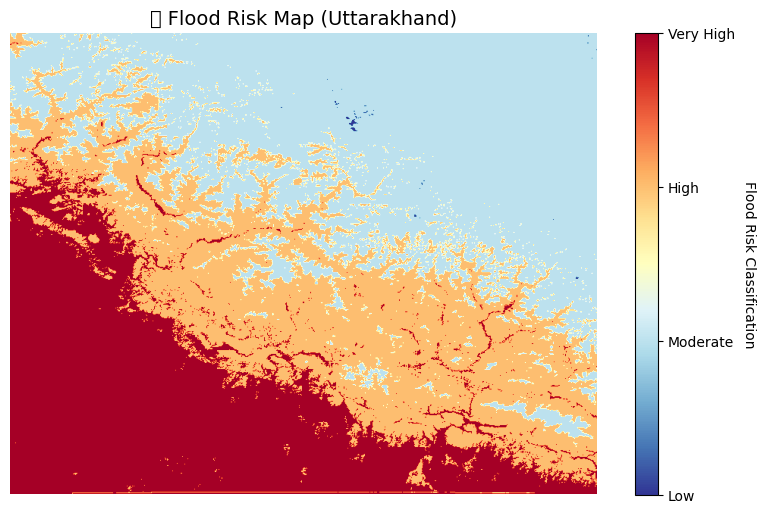

✅ Exported classified raster to outputs\output.tif


In [182]:
path = generate_flood_risk_map(
    dem_path="downloads/uttarakhand_dem.tif",
    ndvi_path="downloads/uttarakhand_ndvi.tif",
    rainfall_path="downloads/uttarakhand_rainfall.tif",
    lulc_path="downloads/uttarakhand_lulc.tif"
)


In [183]:
import rasterio
from rasterio.mask import mask
from rasterio.transform import array_bounds
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import os

class VisualizeFloodRiskInput(BaseModel):
    raster_path: str
    boundary_geojson_path: str
    output_png_path: str
    output_html_path: str
    colormap: str = 'RdYlBu_r'
    opacity: float = 0.6
    zoom_start: int = 8

def visualize_flood_risk_folium(
    **kwargs
):
    input = VisualizeFloodRiskInput(**kwargs)
    raster_path = input.raster_path
    boundary_geojson_path = input.boundary_geojson_path
    output_png_path = input.output_png_path
    output_html_path = input.output_html_path
    colormap = input.colormap
    opacity = input.opacity
    zoom_start = input.zoom_start
    # --- Ensure output directories exist ---
    # --- Load boundary ---
    gdf = gpd.read_file(boundary_geojson_path)

    # --- Clip raster to boundary ---
    with rasterio.open(raster_path) as src:
        gdf = gdf.to_crs(src.crs)  # Ensure CRS match
        clipped, clipped_transform = mask(src, gdf.geometry, crop=True)
        clipped_meta = src.meta.copy()

    # --- Normalize for display ---
    raster_data = clipped[0]
    raster_data = np.where(raster_data == 0, np.nan, raster_data)
    norm_data = (raster_data - np.nanmin(raster_data)) / (np.nanmax(raster_data) - np.nanmin(raster_data))

    # --- Save RGB image using colormap ---
    cmap = plt.get_cmap(colormap)
    rgba_img = cmap(norm_data)
    plt.imsave(output_png_path, rgba_img)

    # --- Compute bounds ---
    height, width = raster_data.shape
    minx, miny, maxx, maxy = array_bounds(height, width, clipped_transform)
    center_lat = (miny + maxy) / 2
    center_lon = (minx + maxx) / 2

    # --- Build Folium map ---
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start, tiles="OpenStreetMap")

    image_overlay = folium.raster_layers.ImageOverlay(
        name='Flood Risk (Clipped)',
        image=output_png_path,
        bounds=[[miny, minx], [maxy, maxx]],
        opacity=opacity,
        interactive=True,
        cross_origin=False,
        zindex=1
    )

    image_overlay.add_to(m)
    folium.LayerControl().add_to(m)
    m.save(output_html_path)

    print(f"✅ Map created: {output_html_path}")


In [185]:
visualize_flood_risk_folium(
    raster_path="./outputs/output.tif",
    boundary_geojson_path="./uttarakhand_.geojson",
    output_png_path="./outputs/flood_overlay_clipped.png",
    output_html_path="./outputs/flood_map_osm.html"
)


✅ Map created: ./outputs/flood_map_osm.html


In [186]:
!pip freeze>requirements.txt